# Lista de Exercícios 4: Gradiente de Política

#### Disciplina: Aprendizado por Reforço
#### Professor: Luiz Chaimowicz
#### Monitores: Marcelo Lemos e Ronaldo Vieira

---

## Instruções

- ***SUBMISSÕES QUE NÃO SEGUIREM AS INSTRUÇÕES A SEGUIR NÃO SERÃO AVALIADAS.***
- Leia atentamente toda a lista de exercícios e familiarize-se com o código fornecido antes de começar a implementação.
- Os locais onde você deverá escrever suas soluções estão demarcados com comentários `# YOUR CODE HERE` ou `YOUR ANSWER HERE`.
- **Não altere o código fora das áreas indicadas, nem adicione ou remova células. O nome deste arquivo também não deve ser modificado.**
- Antes de submeter, certifique-se de que o código esteja funcionando do início ao fim sem erros.
- Submeta apenas este notebook (*ps4.ipynb*) com as suas soluções no Moodle.
- Prazo de entrega: 20/11/2025. Submissões fora do prazo terão uma penalização de -20% da nota final por dia de atraso.
- Utilize a [documentação do Gymnasium](https://gymnasium.farama.org/) para auxiliar sua implementação.
- Em caso de dúvidas entre em contato pelo fórum "Dúvidas com relação aos exercícios e trabalho de curso" no moodle da Disciplina.

---

## Cart Pole

Cart Pole é um ambiente no qual o agente precisa equilibrar um pêndulo invertido acoplado a um carrinho que se move horizontalmente. O objetivo é evitar que o pêndulo caia, controlando a posição do carrinho de maneira apropriada. O desafio está em manter o equilíbrio do sistema aplicando forças para a esquerda ou para a direita, de modo a contrabalançar a inclinação do pêndulo.

![Cart Pole](https://gymnasium.farama.org/_images/cart_pole.gif)

O espaço de observação é contínuo e composto por quatro variáveis: a posição e a velocidade do carrinho, o ângulo do pêndulo e a velocidade angular do pêndulo. O agente pode escolher entre duas ações discretas: aplicar uma força no carrinho para a esquerda ou para a direita. O estado inicial de cada episódio é definido de forma aleatória, com todos os valores dentro do intervalo $(−0.05, 0.05)$. O sempre sistema começa em uma configuração próxima do equilíbrio vertical, mas com pequenas variações.

O episódio termina quando o ângulo do pêndulo em relação ao eixo vertical excede 12 graus, quando o carrinho se afasta mais de 2.4 unidades de distância do centro, ou quando o limite de 500 passos é atingido. A cada passo, o agente recebe uma recompensa de $1$, incentivando-o a manter o sistema estável pelo maior tempo possível. Para mais detalhes sobre o ambiente leia a [documentação do gymnasium](https://gymnasium.farama.org/environments/classic_control/cart_pole/).

Nesta lista de exercícios, você irá trabalhar com o ambiente Cart Pole descrito acima. Seu objetivo será implementar o algoritmo REINFORCE para solucionar este problema.

## REINFORCE

Nesta atividade, você implementará um agente baseado no algoritmo REINFORCE, utilizando uma **política linear com softmax**. Você será responsável por definir e inicializar os pesos da política, calcular o gradiente da função objetivo e realizar a atualização dos parâmetros ao longo do treinamento.

Siga as instruções abaixo para implementar seu agente:

1. Implemente o método `__init__` que inicializa um novo agente. Ele deve receber como parâmetros o espaço de observações, o espaço de ações, a taxa de aprendizado $\alpha$, e o fator de desconto $\gamma$. Inicialize os pesos do modelo na variável `self.weights`.
2. Implemente o método `softmax`, que recebe um vetor de preferências (logits) $z = (z_1,\dotsc,z_K) \in \mathbb{R}^K$ e retorna as prob.s de cada ação segundo a função softmax $\sigma(z)_i = \frac{e^{z_i}}{\sum_{j=1}^{K} e^{z_j}}$, para $i = 1, \dotsc, K.$
3. Implemente o método `choose_action`, responsável por escolher uma ação a partir de um estado observado.
4. Implemente o método `learn`, que atualiza os pesos do agente com base na experiência obtida durante a interação com o ambiente.
5. Implemente o método `train`, que executa o loop de treinamento do algoritmo REINFORCE. O ambiente de treinamento e o número de episódios devem ser fornecidos como parâmetros de entrada. O método deve retornar uma lista com a soma das recompensas obtidas ao longo de cada episódio.

In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class ReinforceAgent:
    def __init__(self, observation_space, action_space, alpha, gamma):
        """
        Init agent REINFORCE.


        Args:
            observation_space: obs space Gymnasium
            action_space: action space Gymnasium
            alpha (float):learning rate.
            gamma (float): discount factor.
        """
        self.obs_dim = observation_space.shape[0]  # 4 para o CartPole
        self.n_actions = action_space.n          # 2 para o CartPole
        self.alpha = alpha
        self.gamma = gamma
        self.weights = np.zeros((self.obs_dim, self.n_actions))

    def softmax(self, z):
        """
        Cal func softmax de forma numericamente estável.

        Args:
            z (np.array): vector pref action

        Returns:
            np.array: prob vector action.
        """
        stable_z = z - np.max(z)
        exp_z = np.exp(stable_z)
        probs = exp_z / np.sum(exp_z)
        return probs

    def choose_action(self, state):
        """
        Escolhe uma ação com base na política softmax.

        Args:
            state (np.array): obs atual do ambiente.

        Returns:
            int: ação (0 ou 1) escolhida estocasticamente.
        """
        logits = np.dot(state, self.weights)
        probs = self.softmax(logits)
        action = np.random.choice(self.n_actions, p=probs)

        return action

    def learn(self, trajectories):
        """
        Atualiza os pesos da política (θ) usando o algoritmo REINFORCE.

        Args:
            trajectories (list): Uma lista de tuplas (estado, ação, recompensa)
                                 coletadas durante o episódio.
        """
        returns = []
        G = 0.0 # G é o retorno acumulado
        rewards = [r for (s, a, r) in trajectories]

        for r in reversed(rewards):
            G = r + self.gamma * G
            returns.insert(0, G)

        returns = np.array(returns)
        std_dev = np.std(returns) + 1e-9
        returns = (returns - np.mean(returns)) / std_dev


        for t in range(len(trajectories)):
            state, action, _ = trajectories[t]
            G_t = returns[t]
            discount = self.gamma ** t
            logits = np.dot(state, self.weights)
            probs = self.softmax(logits)
            d_logits = -probs
            d_logits[action] += 1.0 # δ[A_t] = 1
            grad_log_pi = np.outer(state, d_logits)
            self.weights += self.alpha * discount * G_t * grad_log_pi

    def train(self, env, episodes):
        """
        loop de treinamento principal

        Args:
            env: env Gymnasium (CartPole-v1).
            episodes (int): num de eps para treinar.

        Returns:
            list: lista contendo a recompensa total de cada eps.
        """
        total_rewards = []

        for _ in range(episodes):
            trajectories = []
            episode_reward = 0.0
            (state, info) = env.reset()

            terminated = False
            truncated = False

            while not terminated and not truncated:
                action = self.choose_action(state)
                (next_state, reward, terminated, truncated, info) = env.step(action)
                trajectories.append((state, action, reward))
                episode_reward += reward
                state = next_state

            self.learn(trajectories)

            total_rewards.append(episode_reward)

        return total_rewards

In [3]:
# Não altere ou remova esta célula

6. Treine um novo agente no ambiente Cart Pole por 2000 episódios. Escolha parâmetros $\alpha$ e $\gamma$ de acordo com o desempenho do seu modelo. Armazene os retornos episódicos, obtidos no método `train`, na variável `reinforce_returns`.

In [4]:
#env = gym.make("CartPole-v1", render_mode="human")
env = gym.make("CartPole-v1")

num_episodes = 2000
learning_rate_alpha = 0.03 # choosen based on experiments, seen in the notebook questions below
discount_factor_gamma = 0.99
obs_space = env.observation_space
act_space = env.action_space

agent = ReinforceAgent(observation_space=obs_space,
                       action_space=act_space,
                       alpha=learning_rate_alpha,
                       gamma=discount_factor_gamma)

print(f"Iniciando o treinamento do REINFORCE por {num_episodes} episódios...")
reinforce_returns = agent.train(env, num_episodes)
print("Treinamento concluído.")

env.close()

Iniciando o treinamento do REINFORCE por 2000 episódios...
Treinamento concluído.


In [5]:
# Não altere ou remova esta célula

## Análise

7. Utilize a biblioteca matplotlib para gerar um gráfico dos retornos episódicos obtidos pelo agente, armazenados na variável `reinforce_returns` no exercício anterior. Caso os dados apresentem muita variação, aplique uma média móvel para suavizar a curva e evidenciar melhor a tendência de aprendizado. Adicione um título e rótulos de eixos apropriados para facilitar a interpretação.

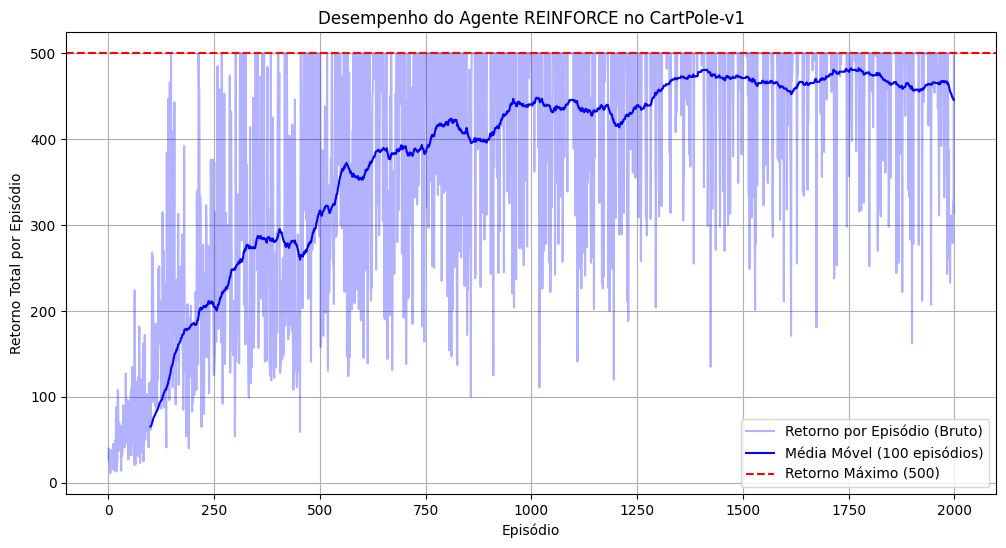

In [6]:
def moving_average(data, window_size):
    data_array = np.array(data)

    return np.convolve(data_array, np.ones(window_size)/window_size, mode='valid')

window_size = 100
smoothed_returns = moving_average(reinforce_returns, window_size)

plt.figure(figsize=(12, 6))
plt.plot(reinforce_returns, label='Retorno por Episódio (Bruto)', color='blue', alpha=0.3)
plt.plot(np.arange(window_size-1, num_episodes),
         smoothed_returns,
         label=f'Média Móvel ({window_size} episódios)',
         color='blue')
plt.title("Desempenho do Agente REINFORCE no CartPole-v1")
plt.xlabel("Episódio")
plt.ylabel("Retorno Total por Episódio")
plt.axhline(y=500, color='r', linestyle='--', label='Retorno Máximo (500)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

8. Durante o treinamento, o seu agente apresentou instabilidades, como variações bruscas na recompensa ou dificuldade em convergir? Que estratégias poderiam ser adotadas para mitigar instabilidades neste algoritmo?

Sim, o agente apresentou instabilidades muito claras, como pode ser visto no gráfico de resultados acima.

A linha azul clara "Retorno por Episódio (Bruto)" mostra variações bruscas e caóticas, oscilando intensamente entre retornos baixos e altos. Isso não é um erro de implementação, mas sim a principal característica (e desvantagem) do algoritmo REINFORCE:

Por sua vez, o REINFORCE é um método Monte Carlo, pois aguarda o retorno completo do episódio ($G_t$) para atualizar a política, levando a um aprendizado lento e instável.

Para mitigar essas instabilidades, a teoria nos aponta duas estratégias principais:

#### 1. Ajuste de Hiperparâmetros:

Executei testes com diferentes valores de $\alpha$ (taxa de aprendizado) por mais de 1h de execução para observar seu impacto no desempenho do agente. Os resultados estão ilustrados no gráfico abaixo:
![Gráfico de Comparação](https://github.com/ARRETdaniel/25-2_aprendizado-por-reforco/blob/main/L4/test4.png?raw=true) 

Esses métodos de gradiente de política são conhecidos por serem muito sensíveis aos hiperparâmetros, especialmente à taxa de aprendizado (tamanho do passo) $\alpha$. Como visto nos gráficos acima, um $\alpha$ inadequado pode levar à divergência ou a uma convergência extremamente lenta. Um ajuste fino, geralmente usando um $\alpha$ mais ideal para o seu problema, é crucial para a estabilidade.

#### 2. Adicionar um Baseline (REINFORCE with Baseline)

A estratégia mais direta para reduzir a variância é subtrair um *baseline* $b(s)$ do retorno $G_t$ na regra de atualização.

Como visto, o baseline reduz a variância da atualização, pois o agente passa a aprender com base em "quão melhor ou pior" a ação foi em relação ao esperado para aquele estado ($b(S_t)$), em vez de aprender com o valor absoluto do retorno $G_t$. Isso é feito sem introduzir bias, pois o valor esperado da atualização não se altera.
* No caso, o baseline natural (e o mais eficaz) é usar uma estimativa da função de valor do estado, $\hat{v}(S_t, w)$. Então, o algoritmo aprende simultaneamente os pesos da política ($\theta$) e os pesos da função de valor ($w$).
    * *Nota: Nossa implementação já usa uma forma de baseline (normalização dos retornos), mas uma função de valor aprendida é uma abordagem mais robusta.*

#### 3. Métodos Actor-Critic (Bootstrapping)

Esta é a evolução do REINFORCE com baseline e a principal estratégia para combater a variância.

A fonte da alta variância é o retorno Monte Carlo ($G_t$), que só é conhecido no final do episódio.
De modo a superar isso, em vez de usar o retorno completo $G_t$, os métodos Actor-Critic usam o *bootstrapping* (como os métodos TD vistos em aula). Eles substituem o termo de retorno $(G_t - b(S_t))$ pelo **TD Error**.
Nesse cenario, o baseline ($\hat{v}$) agora se torna um "Critic". Ele não apenas subtrai a média, mas *avalia* (critica) a ação do "Actor" (a política $\pi$) usando o TD Error.
Por fim, embora o bootstrapping introduza um pequeno viés (bias), ele normalmente permite uma aprendizagem mais estável e eficiente, pois reduz drasticamente a variância.


9. Explique qual é o papel da função softmax na definição da política. Por que, nesse contexto, não é suficiente escolher apenas a ação com maior valor?

O papel da função softmax é duplo e fundamental para os métodos de gradiente de política:

Dado que a política é definida por uma função de "preferência" $h(s, a, \theta)$, que pode retornar qualquer valor real (logits). A função softmax normaliza essas preferências, transformando-as em uma **distribuição de prob. válida**. Isso garante que cada ação tenha uma prob. entre 0 e 1, e que a soma das probs. de todas as ações em um estado seja exatamente 1.

Uma das propriedades da função softmax é que ela é suave e **diferenciável** em relação aos parâmetros $\theta$. Os métodos de gradiente de política funcionam fazendo uma "subida de gradiente" (gradient ascent), ou seja, ajustando os parâmetros $\theta$ na direção que mais aumenta a performance $J(\theta)$. Sem uma política diferenciável, não poderíamos calcular o gradiente $\nabla J(\theta)$ e, portanto, não poderíamos usar esses métodos.

Não é suficiente escolher apenas a ação com o maior valor (uma política *greedy* ou `argmax`, como a usada em Q-learning ou $\epsilon$-greedy) por duas razões principais:

1.  **A Função `argmax` Não é Diferenciável:** Uma seleção *greedy* (escolher o máximo) é uma função descontínua. Uma pequena mudança nos parâmetros $\theta$ pode não causar nenhuma mudança na ação escolhida (resultando em um gradiente zero) ou pode causar uma mudança abrupta para uma ação completamente diferente (gradiente indefinido). Isso torna impossível o aprendizado via subida de gradiente. 

2.  **Incapacidade de Aprender Políticas Estocásticas Ótimas:** Em muitos problemas, especialmente os com aproximação de função ou estados ambíguos, a política ótima *não* é determinística, mas sim **estocástica**. O exemplo do "Short Corridor" visto em aula ilustra isso perfeitamente: a política ótima é escolher "direita" com 59% de chance e "esquerda" com 41%.
    * Uma política $\epsilon$-greedy só consegue ser *quase*-determinística.
    * O Softmax é capaz de aprender e representar *qualquer* distribuição de prob., permitindo que ele convirja para a política estocástica ótima. E

10. Por que o algoritmo REINFORCE precisa aguardar a conclusão de todo o episódio antes de realizar atualizações nos parâmetros da política?

REINFORCE precisa aguardar a conclusão de todo o episódio porque ele é um método **Monte Carlo (MC) Policy Gradient**.

A sua regra de atualização de política, que é aplicada para cada passo $t$ do episódio, depende diretamente do **retorno completo** (o ganho), $G_t$.
